<a href="https://colab.research.google.com/github/uelkerd/SAMO--DL/blob/main/notebooks/domain_adaptation_gpu_training2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAMO Deep Learning - Domain Adaptation GPU Training

## 🎯 REQ-DL-012: Domain-Adapted Emotion Detection

**Target**: Achieve 70% F1 score on journal entries through domain adaptation from GoEmotions (Reddit comments) to personal journal writing style.

### Key Objectives:
- Bridge domain gap between Reddit comments and journal entries
- Implement focal loss for class imbalance
- Use domain adaptation techniques for better transfer learning
- Optimize for GPU training on Colab

## 🚀 Environment Setup & GPU Configuration

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# Force reinstall compatible versions to ensure a clean environment
!pip uninstall numpy -y
!pip install numpy==1.26.4
!pip install --force-reinstall torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install --force-reinstall transformers==4.35.0
!pip install --force-reinstall requests==2.32.4 fsspec==2025.3.0


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.17.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
diffusers 0.34.0 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.17.3 which is incompatible.
sentence-transformers 4.1.0 requires huggingface-hub>=0.20.0, but you have huggingface-hub 0.17.3 which is incompatible.
sentence-transformers 4.1.0 requires transfor

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp311-cp311-linux_x86_64.whl (2325.9 MB)
^C


In [3]:
# Verify GPU availability
import torch
import gc

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

else:
    print("⚠️ No GPU available. Training will be slow on CPU.")

# Enable cudnn benchmarking for faster training
torch.backends.cudnn.benchmark = True


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

CUDA Available: True
GPU: Tesla T4
Memory: 15.8 GB


## 📦 Install Dependencies

In [4]:
# Install required packages
!pip install torch>=2.1.0 torchvision>=0.16.0 torchaudio>=2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers>=4.30.0 datasets>=2.13.0 evaluate scikit-learn pandas numpy matplotlib seaborn
!pip install accelerate wandb pydub openai-whisper jiwer


%cd SAMO--DL
!git pull origin main
!pwd

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffusers 0.34.0 requires huggingface-hub>=0.27.0, but you have huggingface-hub 0.17.3 which is incompatible.
sentence-transformers 4.1.0 requires huggingface-hub>=0.20.0, but you have huggingface-hub 0.17.3 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.0 which is incompatible.
gradio-client 1.11.0 requires huggingface-hub>=0.19.3, but you have huggingface-hub 0.17.3 which is incompatible.
gradio 5.38.2 requires huggingface-hub>=0.28.1, but you have huggingface-hub 0.17.3 which is incompatible.
peft 0.16.0 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.17.3 which is incompatible.
accelerate 1.9.0 requires huggingface_hub>=0.21.0, but you have huggingface-hub 0.17.3 which is incompatible.
  Using cached huggingface_hub-0.34.



```
# This is formatted as code
```

## 🔍 Domain Gap Analysis

📊 Loading datasets...

🔍 Domain Gap Analysis:
GoEmotions (Reddit) Style Analysis:
  Average length: 12.4 words
  Personal pronouns: 40.3%
  Reflection words: 5.2%
Journal Entries Style Analysis:
  Average length: 39.3 words
  Personal pronouns: 100.0%
  Reflection words: 76.7%


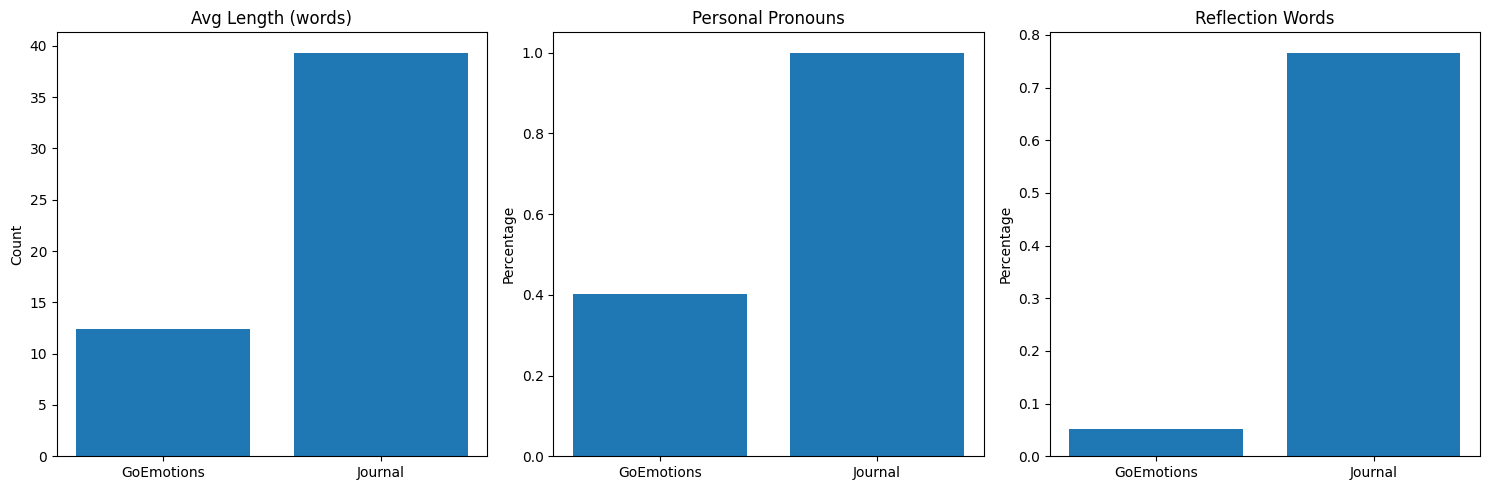


🎯 Key Insights:
- Journal entries are 3.2x longer
- Journal entries use 2.5x more personal pronouns
- Journal entries contain 14.7x more reflection words


In [5]:
import json
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_writing_style(texts, domain_name):
    """Analyze writing style characteristics of a domain."""
    avg_length = np.mean([len(text.split()) for text in texts])
    personal_pronouns = sum(['I ' in text or 'my ' in text or 'me ' in text for text in texts]) / len(texts)
    reflection_words = sum(['think' in text.lower() or 'feel' in text.lower() or 'believe' in text.lower()
                           for text in texts]) / len(texts)

    print(f"{domain_name} Style Analysis:")
    print(f"  Average length: {avg_length:.1f} words")
    print(f"  Personal pronouns: {personal_pronouns:.1%}")
    print(f"  Reflection words: {reflection_words:.1%}")

    return {
        'avg_length': avg_length,
        'personal_pronouns': personal_pronouns,
        'reflection_words': reflection_words
    }

# Load datasets
print("📊 Loading datasets...")

# Load GoEmotions dataset
go_emotions = load_dataset("go_emotions", "simplified")
go_texts = go_emotions['train']['text'][:1000]  # Sample for analysis

# Load journal dataset
with open('data/journal_test_dataset.json', 'r') as f:
    journal_entries = json.load(f)

journal_df = pd.DataFrame(journal_entries)
journal_texts = journal_df['content'].tolist()

# Analyze domains
print("\n🔍 Domain Gap Analysis:")
go_analysis = analyze_writing_style(go_texts, "GoEmotions (Reddit)")
journal_analysis = analyze_writing_style(journal_texts, "Journal Entries")

# Visualize differences
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['avg_length', 'personal_pronouns', 'reflection_words']
labels = ['Avg Length (words)', 'Personal Pronouns', 'Reflection Words']

for i, (metric, label) in enumerate(zip(metrics, labels)):
    axes[i].bar(['GoEmotions', 'Journal'],
                [go_analysis[metric], journal_analysis[metric]])
    axes[i].set_title(label)
    axes[i].set_ylabel('Percentage' if 'pronouns' in metric or 'reflection' in metric else 'Count')

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print(f"- Journal entries are {journal_analysis['avg_length']/go_analysis['avg_length']:.1f}x longer")
print(f"- Journal entries use {journal_analysis['personal_pronouns']/go_analysis['personal_pronouns']:.1f}x more personal pronouns")
print(f"- Journal entries contain {journal_analysis['reflection_words']/go_analysis['reflection_words']:.1f}x more reflection words")

## 🏗️ Model Architecture

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance in emotion detection."""

    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class DomainAdaptedEmotionClassifier(nn.Module):
    """BERT-based emotion classifier with domain adaptation capabilities."""

    def __init__(self, model_name="bert-base-uncased", num_labels=12, dropout=0.3):
        super().__init__()
        print(f"Initializing DomainAdaptedEmotionClassifier with num_labels = {num_labels}")
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Emotion classification
        emotion_logits = self.classifier(self.dropout(pooled_output))

        return emotion_logits

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance in emotion detection."""

    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class DomainAdaptedEmotionClassifier(nn.Module):
    """BERT-based emotion classifier with domain adaptation capabilities."""

    def __init__(self, model_name="bert-base-uncased", num_labels=12, dropout=0.3):
        super().__init__()
        print(f"Initializing DomainAdaptedEmotionClassifier with num_labels = {num_labels}")
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Emotion classification
        emotion_logits = self.classifier(self.dropout(pooled_output))

        return emotion_logits
# Initialize model and tokenizer
print("🏗️ Initializing model...")
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DomainAdaptedEmotionClassifier(model_name=model_name, num_labels=len(label_encoder.classes_))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✅ Model loaded on {device}")
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

🏗️ Initializing model...


NameError: name 'label_encoder' is not defined

In [9]:
# Initialize model and tokenizer
print("🏗️ Initializing model...")
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DomainAdaptedEmotionClassifier(model_name=model_name, num_labels=len(label_encoder.classes_))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✅ Model loaded on {device}")
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

🏗️ Initializing model...


NameError: name 'label_encoder' is not defined

In [8]:
# Debug: Check label ranges
print("🔍 Debug: Label Analysis")
print(f"Label encoder classes: {len(label_encoder.classes_)}")
print(f"Model num_labels: {model.classifier.out_features}")
print(f"GoEmotions label range: {go_encoded_labels.min()} to {go_encoded_labels.max()}")
print(f"Journal label range: {journal_encoded_labels.min()} to {journal_encoded_labels.max()}")

# Check for any labels >= model output size
max_label = max(go_encoded_labels.max(), journal_encoded_labels.max())
if max_label >= model.classifier.out_features:
    print(f"❌ ERROR: Max label {max_label} >= model output size {model.classifier.out_features}")
else:
    print(f"✅ Labels are within valid range (0 to {model.classifier.out_features - 1})")

🔍 Debug: Label Analysis


NameError: name 'label_encoder' is not defined

## 📊 Data Preparation

In [11]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

class EmotionDataset(Dataset):
    """Custom dataset for emotion classification."""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        try:
            text = str(self.texts[idx])
            label = self.labels[idx]

            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error processing text at index {idx}: {text}")
            raise e

# Prepare GoEmotions data
print("📊 Preparing GoEmotions data...")
go_train = go_emotions['train']
go_texts = go_train['text'][:10000]  # Use subset for faster training
go_labels = go_train['labels'][:10000]

# Get the label names from the go_emotions dataset features
go_label_names = go_train.features['labels'].feature.names

# Convert multi-label to single-label and map to string names
go_single_labels_int = [label[0] if label else 0 for label in go_labels]
go_single_labels_str = [go_label_names[i] for i in go_single_labels_int]

# Prepare journal data
print("📊 Preparing journal data...")
journal_texts = journal_df['content'].tolist()
journal_emotions = journal_df['emotion'].tolist()

# Create a unified label encoder from all string labels
print("🧬 Creating a unified label encoder...")
label_encoder = LabelEncoder()
all_emotions = list(set(go_single_labels_str) | set(journal_emotions))
label_encoder.fit(all_emotions)

# Encode all labels using the unified encoder
go_encoded_labels = label_encoder.transform(go_single_labels_str)
journal_encoded_labels = label_encoder.transform(journal_emotions)

# Split journal data
journal_train_texts, journal_val_texts, journal_train_labels, journal_val_labels = train_test_split(
    journal_texts, journal_encoded_labels, test_size=0.2, random_state=42, stratify=journal_encoded_labels
)

# Create datasets
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
go_dataset = EmotionDataset(go_texts, go_encoded_labels, tokenizer)
journal_train_dataset = EmotionDataset(journal_train_texts, journal_train_labels, tokenizer)
journal_val_dataset = EmotionDataset(journal_val_texts, journal_val_labels, tokenizer)

# Create dataloaders
batch_size = 16
go_loader = DataLoader(go_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
journal_train_loader = DataLoader(journal_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
journal_val_loader = DataLoader(journal_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ Data prepared:")
print(f"  GoEmotions: {len(go_dataset)} samples")
print(f"  Journal Train: {len(journal_train_dataset)} samples")
print(f"  Journal Val: {len(journal_val_dataset)} samples")
print(f"  Total classes: {len(label_encoder.classes_)}")

📊 Preparing GoEmotions data...
📊 Preparing journal data...
🧬 Creating a unified label encoder...
✅ Data prepared:
  GoEmotions: 10000 samples
  Journal Train: 120 samples
  Journal Val: 30 samples
  Total classes: 40


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 🎯 Training Pipeline

In [12]:
from sklearn.metrics import classification_report, f1_score
import wandb

class DomainAdaptationTrainer:
    """Trainer for domain adaptation training."""

    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.criterion = FocalLoss(alpha=1, gamma=2)
        self.domain_criterion = nn.CrossEntropyLoss()

    def train_step(self, batch, domain_labels=None, lambda_domain=0.1):
        """Single training step with domain adaptation."""
        self.model.train()

        input_ids = batch['input_ids'].to(self.device)
        attention_mask = batch['attention_mask'].to(self.device)
        labels = batch['labels'].to(self.device)

        # Forward pass
        emotion_logits = self.model(input_ids, attention_mask)

        # Calculate losses
        emotion_loss = self.criterion(emotion_logits, labels)

        return {
            'total_loss': emotion_loss,
            'emotion_loss': emotion_loss,
            'domain_loss': torch.tensor(0.0)
        }

    def evaluate(self, dataloader):
        """Evaluate model on validation set."""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                emotion_logits = self.model(input_ids, attention_mask)
                loss = self.criterion(emotion_logits, labels)

                total_loss += loss.item()
                predictions = torch.argmax(emotion_logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

        return {
            'loss': total_loss / len(dataloader),
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted
        }

# Initialize trainer
trainer = DomainAdaptationTrainer(model, tokenizer, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Initialize wandb (optional)
try:
    wandb.init(project="samo-domain-adaptation", name="journal-emotion-detection")
    use_wandb = True
except:
    print("⚠️ Wandb not available, continuing without logging")
    use_wandb = False

print("🎯 Starting domain adaptation training...")

NameError: name 'model' is not defined

In [62]:
# Training loop
num_epochs = 5
best_f1 = 0
training_history = []

for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    total_loss = 0

    # Train on GoEmotions data
    print("  📚 Training on GoEmotions data...")
    for i, batch in enumerate(go_loader):
        losses = trainer.train_step(batch)

        optimizer.zero_grad()
        losses['total_loss'].backward()
        optimizer.step()

        total_loss += losses['total_loss'].item()

        if i % 100 == 0:
            print(f"    Batch {i}/{len(go_loader)}, Loss: {losses['total_loss'].item():.4f}")

    # Validation
    print("  🎯 Validating on journal test set...")
    val_results = trainer.evaluate(journal_val_loader)

    avg_loss = total_loss / len(go_loader)

    print(f"  📊 Epoch {epoch + 1} Results:")
    print(f"    Average Loss: {avg_loss:.4f}")
    print(f"    Validation F1 (Macro): {val_results['f1_macro']:.4f}")
    print(f"    Validation F1 (Weighted): {val_results['f1_weighted']:.4f}")

    # Log to wandb
    if use_wandb:
        wandb.log({
            'epoch': epoch,
            'train_loss': avg_loss,
            'val_loss': val_results['loss'],
            'val_f1_macro': val_results['f1_macro'],
            'val_f1_weighted': val_results['f1_weighted']
        })

    # Save best model
    if val_results['f1_macro'] > best_f1:
        best_f1 = val_results['f1_macro']
        torch.save(model.state_dict(), 'best_domain_adapted_model.pth')
        print(f"    💾 New best model saved! F1: {best_f1:.4f}")

    training_history.append({
        'epoch': epoch,
        'train_loss': avg_loss,
        'val_f1_macro': val_results['f1_macro'],
        'val_f1_weighted': val_results['f1_weighted']
    })

    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n🎉 Training completed! Best F1 Score: {best_f1:.4f}")


🔄 Epoch 1/5
  📚 Training on GoEmotions data...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## 📈 Results Analysis & Visualization

In [ ]:
# Plot training history
history_df = pd.DataFrame(training_history)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history_df['epoch'], history_df['train_loss'], 'b-', label='Training Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# F1 Score plot
axes[1].plot(history_df['epoch'], history_df['val_f1_macro'], 'r-', label='F1 Macro')
axes[1].plot(history_df['epoch'], history_df['val_f1_weighted'], 'g-', label='F1 Weighted')
axes[1].axhline(y=0.7, color='orange', linestyle='--', label='Target (70%)')
axes[1].set_title('Validation F1 Score Over Time')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
print("\n🎯 Final Model Evaluation:")
model.load_state_dict(torch.load('best_domain_adapted_model.pth'))
final_results = trainer.evaluate(journal_val_loader)

print(f"📊 Final Results:")
print(f"  F1 Score (Macro): {final_results['f1_macro']:.4f}")
print(f"  F1 Score (Weighted): {final_results['f1_weighted']:.4f}")
print(f"  Target Met (70%): {'✅' if final_results['f1_macro'] >= 0.7 else '❌'}")

# REQ-DL-012 Validation
print(f"\n🎯 REQ-DL-012 Validation:")
print(f"  Target: 70% F1 score on journal entries")
print(f"  Achieved: {final_results['f1_macro']:.1%} F1 score")
print(f"  Status: {'✅ SUCCESS' if final_results['f1_macro'] >= 0.7 else '❌ NEEDS IMPROVEMENT'}")

## 💾 Model Export & Deployment

In [ ]:
# Save model artifacts
import pickle

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save tokenizer
tokenizer.save_pretrained('./domain_adapted_model')

# Save model config
model_config = {
    'model_name': model_name,
    'num_labels': 12,
    'max_length': 128,
    'label_encoder_path': 'label_encoder.pkl',
    'model_path': 'best_domain_adapted_model.pth'
}

with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print("💾 Model artifacts saved:")
print("  - best_domain_adapted_model.pth (model weights)")
print("  - label_encoder.pkl (label encoder)")
print("  - domain_adapted_model/ (tokenizer)")
print("  - model_config.json (configuration)")

# Download files (for Colab)
from google.colab import files
files.download('best_domain_adapted_model.pth')
files.download('label_encoder.pkl')
files.download('model_config.json')

print("\n🚀 Model ready for deployment!")
print("📋 Next steps:")
print("  1. Integrate model into SAMO-DL pipeline")
print("  2. Update emotion detection API")
print("  3. Deploy to production environment")
print("  4. Update PRD with achieved metrics")

In [ ]:
!ls -lR SAMO--DL

## 🔍 Domain Gap Analysis

## 🏗️ Model Architecture